# Collaborative Filtering

Collaborative filtering predicts ratings based on past user behavior, which is characterized by previous ratings in this case. To perform collaborative filtering, we only need to use restaurant ratings from each user. We acquire data for this part by keeping 3 features in `review` table, `user_id`, `business_id`, and `stars`.

Collaborative filtering includes 2 primary areas, **neighborhood methods** and **latent factor models**. In this part, we tested several baseline models, neighborhood methods and latent factor models. We implemented some baseline models and latent factor models from scratch (by using `numpy` and `scipy`'s linear algebra toolkits instead of well-established recommender system packages); we implemented other algorithms by wrapping around methods in a recommender system python package, [scikit-surprise](http://surpriselib.com/). Each algorithm we implemented by using the [scikit-surprise](http://surpriselib.com/) package is indicated by a * after its name.

In [1]:
import sys
import traceback
import pandas as pd
import numpy as np
import time
from copy import deepcopy

from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from scipy import sparse

import pickle

from IPython.display import display, HTML, Markdown

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
pd.set_option('display.width', 15000)
pd.set_option('display.max_columns', 100)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context('poster')
%matplotlib inline

from surprise import Dataset, Reader
from surprise import NormalPredictor, BaselineOnly, SVD, SVDpp, NMF, \
SlopeOne, CoClustering, KNNBasic, KNNWithMeans, KNNBaseline

from recommender import plot_cm, get_results, show_results, IO, \
show_summaries, get_base_predictions, get_multi_base_predictions
from recommender import ModeClassifier, BaselineMean, BaselineRegression, ALS1, ALS2, RS_surprise, RS_ensemble

In [2]:
# Load data

city = 'Champaign'
data_dir = 'data/{}/'.format(city)

dfb = pd.read_pickle(data_dir + 'business.pkl')
dfr = pd.read_pickle(data_dir + 'review.pkl')
dfu = pd.read_pickle(data_dir + 'user.pkl')
datar = pd.read_pickle(data_dir + 'data_review.pkl')

sizes = [datar.shape[0], dfb.shape[0], dfu.shape[0]]

display(Markdown('Here, we use Champaign dataset ({} reviews, {} restaurants, {} users) for demo purpose.'.\
                format(sizes[0], sizes[1], sizes[2])))

Here, we use Champaign dataset (20571 reviews, 878 restaurants, 8451 users) for demo purpose.

We randomly split the reviews into 3 sets: a training set (60%), a cross-validation set (16%) and a test set (24%). We train base estimators on the training set, and test on the test set; cross-validation set is used for the training of ensemble estimators later.

For each model, we report root mean square error (RMSE) and $R^2$ score on training set and test set. To gain some insight on model's performance on different ratings, we round predicted ratings, where predicted ratings below 1 are rounded to 1 and predicted ratings above 5 are round to 5, and plot the confusion matrix of training set and test set (in a format used in [a related work](https://github.com/kevin11h/YelpDatasetChallengeDataScienceAndMachineLearningUCSD/blob/master/Yelp%20Predictive%20Analytics.ipynb)).

In [3]:
# Split the dataset into a training set, a cross-validation set and a test set

X_train, X_test, y_train, y_test = train_test_split(datar[['user_id', 'business_id']].values, datar['stars'].values, \
                                                   test_size=0.4, random_state=0)
X_cv, X_test, y_cv, y_test = train_test_split(X_test, y_test, test_size=0.6, random_state=0)

data_split = [X_train, y_train, X_test, y_test, X_cv, y_cv]

## Baseline models

We first built some baseline models, including **mode estimator**, **normal predictor\***, **baseline (mean)**, **baseline (regression)**, and **baseline (ALS)\***.

### Mode estimator

Inspired by the fact that most ratings are 5 from EDA part, we build a mode estimator, which predicts every rating as the mode value of all ratings.

In [4]:
class ModeClassifier:
    def __init__(self, mode=5, classification=None):
        self.mode = mode
        self.fitted = True
        self.time_fitting = []
        self.classification = classification
        self.cv_r2 = None
        
    def fit(self, X, y):
        t0 = time.time()
        self.time_fitting.append(time.time() - t0)
        return self
    
    def predict(self, X, classification=None):
        return self.mode * np.ones(len(X))
    
    def score(self, X, y, classification=None, scoring='r2'):
        if classification is None:
            classification = self.classification
        if not classification:
            if scoring == 'r2':
                return r2_score(y, self.predict(X, classification))
            elif scoring == 'mse':
                return mean_squared_error(y, self.predict(X, classification))
            elif scoring == 'rmse':
                return np.sqrt(mean_squared_error(y, self.predict(X, classification)))
            else:
                raise NotImplementedError('`scoring` should be either "r2", "mse", or "rmse".')
        else:
            return accuracy_score(y, self.predict(X, classification))

In [5]:
es = ModeClassifier().fit(X_train, y_train)
model_name = 'Mode estimator'

results = get_results(es, X_train, y_train, X_test, y_test, X_cv, y_cv)

show_summaries([model_name], [results], [True]);

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Mode estimator,0.0,1.9995,2.0258,-0.9501,-0.95


As we mentioned earlier, we could plot a confusion matrix to gain some insight on model's performance on different ratings by rounding the predicted ratings, setting predictions below 1 to 1, above 5 to 5, and using a format used in [a related work](https://github.com/kevin11h/YelpDatasetChallengeDataScienceAndMachineLearningUCSD/blob/master/Yelp%20Predictive%20Analytics.ipynb) (the same below).

We plot the confusion matrix for training set on the left, and that for test set on the right (the same below).

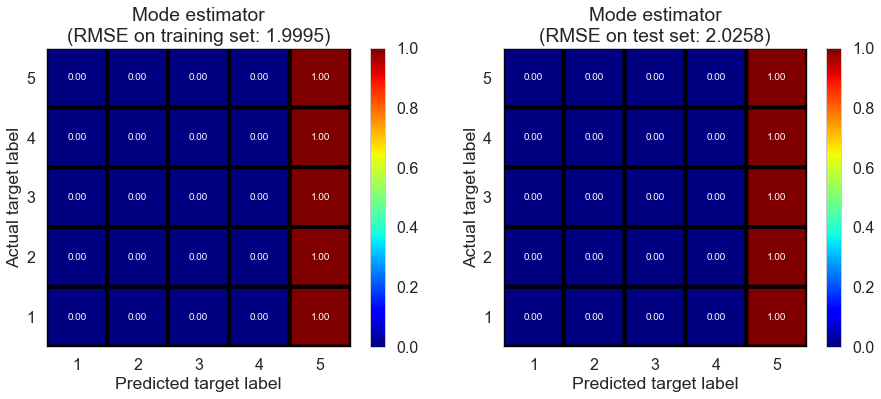

In [6]:
show_results(es, model_name, X_train, y_train, X_test, y_test, results=results, print_=False, plot=True, \
            show_cv=False, show_title=False);

The performance of mode estimator is poor as indicated by negative $R^2$, which is not surprising.

### Normal predictor*
We implemented this algorithm by wrapping around [`NormalPredictor`](http://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.random_pred.NormalPredictor) in the [scikit-surprise](http://surpriselib.com/) package.

As described in the [documentation](http://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.random_pred.NormalPredictor), normal predictor assumes the distribution of the training set to be normal, which doesn't hold in this case. The prediction $\hat{r}_{ui}$ is generated from a normal distribution $\mathcal{N}(\hat{\mu}, \hat{\sigma}^2)$ where $\hat{\mu}$ and $\hat{\sigma}$ are estimated from the training data using the Maximum Likelihood Estimation:
$$\hat{\mu} = \frac{1}{|R_{train}|} \sum_{r_{ui} \in R_{train}} r_{ui}$$
$$\hat{\sigma} = \sqrt{\sum_{r_{ui} \in R_{train}}\frac{(r_{ui} - \hat{\mu})^2}{|R_{train}|}}$$

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Normal predictor*,0.049,1.8612,1.8701,-0.6897,-0.6618


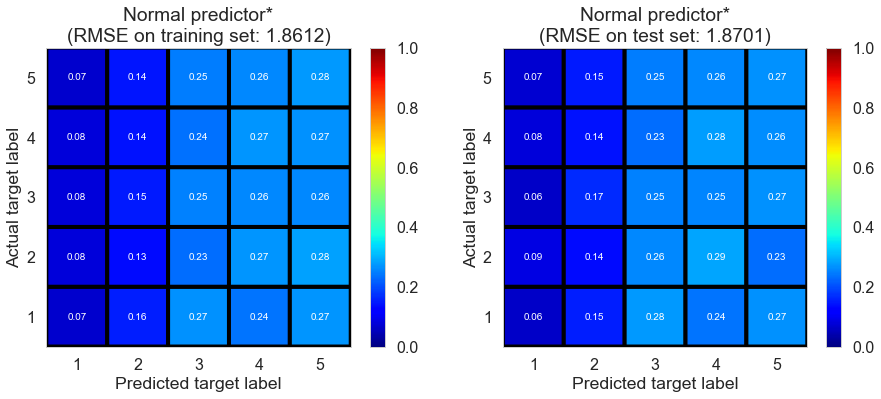

In [28]:
es = RS_surprise(NormalPredictor()).fit(X_train, y_train)
model_name = 'Normal predictor*'

results = get_results(es, X_train, y_train, X_test, y_test, X_cv, y_cv)

show_summaries([model_name], [results], [True]);

show_results(es, model_name, X_train, y_train, X_test, y_test, results=results, print_=False, plot=True, \
            show_cv=False, show_title=False);

The performance of normal predictor is also very poor since rating do NOT satisfy normal distribution (as shown in EDA).

### Baseline (mean)

Here we assume much of variation in observed ratings comes from effects associated with either users or items, known as biases (as assumed in most [latent factor models](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf)). We estimate the ratings as:
$$\hat{r}_{ui} = \mu + b_u + b_i$$

In this model, we estimate biases with sample averages:
$$\hat{b}_u = \bar{r}_u - \mu$$
$$\hat{b}_i = \bar{r}_i - \mu$$
where $\bar{r}_u$ and $\bar{r}_i$ represent average ratings of user $u$ and restaurant $i$ repsectively, $b_u$ and $b_i$ represent the biases of user $u$ and restaurant $i$ repsectively from some intercept parameter $\mu$, which is estimated by the whole sample average in this case.

When we make predictions, if user $u$ is unknown, the bias $b_u$ is assumed to be zero; if the restaurant $i$ is unknown, the bias $b_i$ is assumed to be zero.

In [8]:
class BaselineMean(BaseEstimator):
    def __init__(self, classification=False):
        self.fitted = False
        self.classification = classification
        self.time_fitting = []
        self.time_predict = []
        self.cv_r2 = None
    
    def _fit_id2index(self, X):
        self._user_id_array = np.unique(X[:, 0])
        self._user_id_dict = {self._user_id_array[i]:i for i in range(len(self._user_id_array))}
        self._bus_id_array = np.unique(X[:, 1])
        self._bus_id_dict = {self._bus_id_array[i]:i for i in range(len(self._bus_id_array))}
        self.n_u = len(self._user_id_array)
        self.n_m = len(self._bus_id_array)
        self.n_bp = self.n_u + self.n_m + 1
        return self
        
    def _transform_id2index(self, X):
        X = deepcopy(X)
        X[:, 0] = np.array([self._user_id_dict.get(x, -1) for x in X[:, 0]])
        X[:, 1] = np.array([self._bus_id_dict.get(x, -1) for x in X[:, 1]])
        return X
    
    def _fit_transform_id2index(self, X):
        self._fit_id2index(X)
        X = self._transform_id2index(X)
        return X
    
    def _fit_baseline_mean(self, X, y):
        self.mean_global = np.mean(y)
        self.df = pd.DataFrame(np.concatenate((X, y.reshape(-1, 1)), axis=1))
        self.mean_user_bias = self.df[[0, 2]].groupby(0, as_index=False).mean().sort_values(by=0)[2].values - self.mean_global
        self.mean_bus_bias = self.df[[1, 2]].groupby(1, as_index=False).mean().sort_values(by=1)[2].values - self.mean_global
        return self
    
    def fit(self, X, y):
        t0 = time.time()
        X = self._fit_transform_id2index(X)
        self._fit_baseline_mean(X, y)
        self.fitted = True
        self.time_fitting.append(time.time() - t0)
        return self
    
    def _predict_no_missing(self, X):
        if len(X) == 0:
            return np.array([])
        def _predict_x(x_i):
            return self.mean_global + self.mean_user_bias[x_i[0]] + self.mean_bus_bias[x_i[1]]
        y_pred = np.apply_along_axis(_predict_x, 1, X)
        return y_pred
    
    def _predict_user_missing(self, X):
        if len(X) == 0:
            return np.array([])
        def _predict_x(x_i):
            return self.mean_global + self.mean_bus_bias[x_i[1]]
        y_pred = np.apply_along_axis(_predict_x, 1, X)
        return y_pred
    
    def _predict_bus_missing(self, X):
        if len(X) == 0:
            return np.array([])
        def _predict_x(x_i):
            return self.mean_global + self.mean_user_bias[x_i[0]]
        y_pred = np.apply_along_axis(_predict_x, 1, X)
        return y_pred
        
    def _predict_all_missing(self, X):
        if len(X) == 0:
            return np.array([])
        return self.mean_global * np.ones(len(X))
    
    def _predict_baseline(self, X):
        y_pred = np.zeros(len(X))
        no_missing = np.logical_and(X[:, 0] != -1, X[:, 1] != -1)
        user_missing = np.logical_and(X[:, 0] == -1, X[:, 1] != -1)
        bus_missing = np.logical_and(X[:, 0] != -1, X[:, 1] == -1)
        all_missing = np.logical_and(X[:, 0] == -1, X[:, 1] == -1)
        y_pred[no_missing] = self._predict_no_missing(X[no_missing])
        y_pred[user_missing] = self._predict_user_missing(X[user_missing])
        y_pred[bus_missing] = self._predict_bus_missing(X[bus_missing])
        y_pred[all_missing] = self._predict_all_missing(X[all_missing])
        return y_pred
    
    def _predict_regression(self, X):
        X = self._transform_id2index(X)
        return self._predict_baseline(X)
    
    def _predict_classification(self, X):
        y = self._predict_regression(X)
        y = np.round(y)
        y[y < 1] = 1
        y[y > 5] = 5
        return y.astype(int)
    
    def predict(self, X, classification=None):
        t0 = time.time()
        if not self.fitted:
            raise ValueError('Estimator not fitted.')
        if classification is None:
            classification = self.classification
        if not classification:
            results = self._predict_regression(X)
        else:
            results = self._predict_classification(X)
        self.time_predict.append(time.time() - t0)
        return results
        
    
    def score(self, X, y, classification=None, scoring='r2'):
        if classification is None:
            classification = self.classification
        if not classification:
            if scoring == 'r2':
                return r2_score(y, self.predict(X, classification))
            elif scoring == 'mse':
                return mean_squared_error(y, self.predict(X, classification))
            elif scoring == 'rmse':
                return np.sqrt(mean_squared_error(y, self.predict(X, classification)))
            else:
                raise NotImplementedError('`scoring` should be either "r2", "mse", or "rmse".')
        else:
            return accuracy_score(y, self.predict(X, classification))

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Baseline (mean),0.021,0.9485,1.4648,0.5612,-0.0195


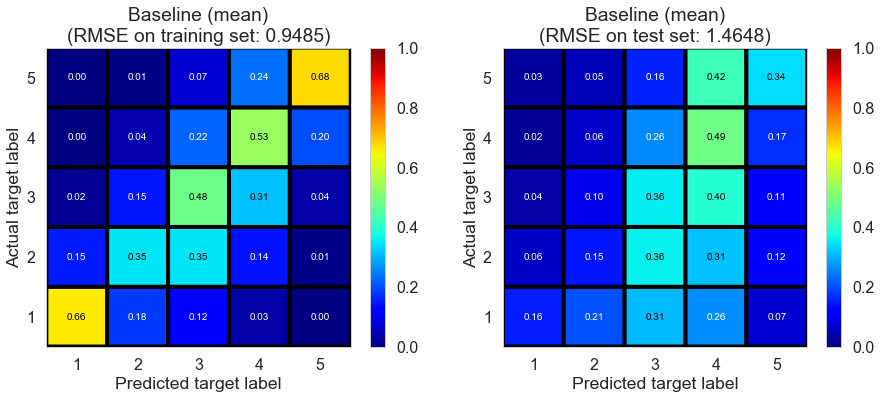

In [9]:
es = BaselineMean().fit(X_train, y_train)
model_name = 'Baseline (mean)'

results = get_results(es, X_train, y_train, X_test, y_test, X_cv, y_cv)

show_summaries([model_name], [results], [True]);

show_results(es, model_name, X_train, y_train, X_test, y_test, results=results, print_=False, plot=True, \
            show_cv=False, show_title=False);

Baseline (mean) performs well on training set; however, it suffers from overfitting as indicated by negative $R^2$ on test set, which is presumably due to the fact that there is no regularization in this model.

### Baseline (regression)

Similarly, we estimate the ratings as:
$$\hat{r}_{ui} = \mu + b_u + b_i$$

In this model, we estimate biases of users and restaurants using regularized regression.  
Specifically, we minimize the following regularized squared error:
$$\sum_{r_{ui} \in R_{train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2 +
\lambda \left(b_u^2 + b_i^2 \right).$$

We perform one-hot encoding on `user_id` and `business_id`, and store the corresponding design matrix as a [sparse matrix](https://docs.scipy.org/doc/scipy/reference/sparse.html). And we solve the Ridge regression algorithm using [LSMR](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.linalg.lsmr.html).

When we make predictions, if user $u$ is unknown, the bias $b_u$ is assumed to be zero; if the restaurant $i$ is unknown, the bias $b_i$ is assumed to be zero.

In [10]:
class BaselineRegression(BaselineMean):
    def __init__(self, alpha=2, classification=False):
        super().__init__(classification)
        self.alpha = alpha
        
    def _sparse_matrix_baseline_regression(self, X, cols=[0, 1]):
        I = np.concatenate([np.arange(len(X)) for _ in range(len(cols) + 1)]).astype(int)
        J = np.zeros(len(X), dtype=int)
        if 0 in cols:
            J = np.concatenate((J, X[:, 0] + 1)).astype(int)
        if 1 in cols:
            J = np.concatenate((J, X[:, 1] + 1 + self.n_u)).astype(int)
        V = np.ones((len(cols) + 1) * len(X))
        A = sparse.coo_matrix((V, (I, J)), shape=(len(X), self.n_bp))
        return A
    
    def _fit_baseline_regression(self, X, y):
        A = self._sparse_matrix_baseline_regression(X, cols=[0, 1])
        self.params_base = sparse.linalg.lsmr(A, y, damp=self.alpha)[0]
        return self
    
    def fit(self, X, y):
        t0 = time.time()
        X = self._fit_transform_id2index(X)
        self._fit_baseline_regression(X, y)
        self.fitted = True
        self.time_fitting.append(time.time() - t0)
        return self
    
    def _predict_no_missing(self, X):
        if len(X) == 0:
            return np.array([])
        A = self._sparse_matrix_baseline_regression(X, cols=[0, 1])
        return A.dot(self.params_base)
    
    def _predict_user_missing(self, X):
        if len(X) == 0:
            return np.array([])
        A = self._sparse_matrix_baseline_regression(X, cols=[1])
        return A.dot(self.params_base)
    
    def _predict_bus_missing(self, X):
        if len(X) == 0:
            return np.array([])
        A = self._sparse_matrix_baseline_regression(X, cols=[0])
        return A.dot(self.params_base)
    
    def _predict_all_missing(self, X):
        if len(X) == 0:
            return np.array([])
        return self.params_base[0] * np.ones(len(X))

We performed 2 rounds of cross-validation to determine the best regularization term $\lambda$.

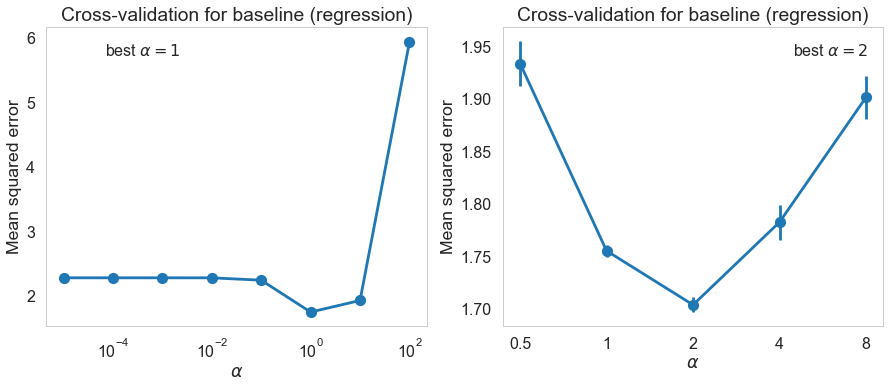

In [11]:
alphas1 = [10**(i-5) for i in range(8)]
gs1 = GridSearchCV(BaselineRegression(classification=False), param_grid={'alpha':alphas1}, scoring='neg_mean_squared_error', \
                  cv=3, return_train_score=True).fit(X_train, y_train)
best_alpha1 = alphas1[np.argmax(gs1.cv_results_['mean_test_score'])]

alphas2 = [0.5, 1, 2, 4, 8]
gs2 = GridSearchCV(BaselineRegression(classification=False), param_grid={'alpha':alphas2}, scoring='neg_mean_squared_error', \
                  cv=3, return_train_score=True).fit(X_train, y_train)
best_alpha2 = alphas2[np.argmax(gs2.cv_results_['mean_test_score'])]

plt.figure(figsize=(15, 5.5))
plt.subplot(1, 2, 1)
plt.errorbar(alphas1, -gs1.cv_results_['mean_test_score'], gs1.cv_results_['std_test_score'], fmt='o-');
plt.semilogx(alphas1, -gs1.cv_results_['mean_test_score'], alpha=0, label=r'best $\alpha = {}$'.format(best_alpha1));
plt.xlabel(r'$\alpha$');
plt.ylabel('Mean squared error');
plt.legend();
plt.title('Cross-validation for baseline (regression)');

plt.subplot(1, 2, 2)
plt.errorbar(alphas2, -gs2.cv_results_['mean_test_score'], gs2.cv_results_['std_test_score'], fmt='o-');
plt.semilogx(alphas2, -gs2.cv_results_['mean_test_score'], alpha=0, label=r'best $\alpha = {}$'.format(best_alpha2));
plt.xlabel(r'$\alpha$');
plt.ylabel('Mean squared error');
plt.xticks(alphas2, alphas2);
plt.legend();
plt.title('Cross-validation for baseline (regression)');

We can test the performance of baseline (regression) using the best regularization parameter determined by the cross-validation.

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Baseline (regression),0.032,1.0481,1.3032,0.4642,0.193


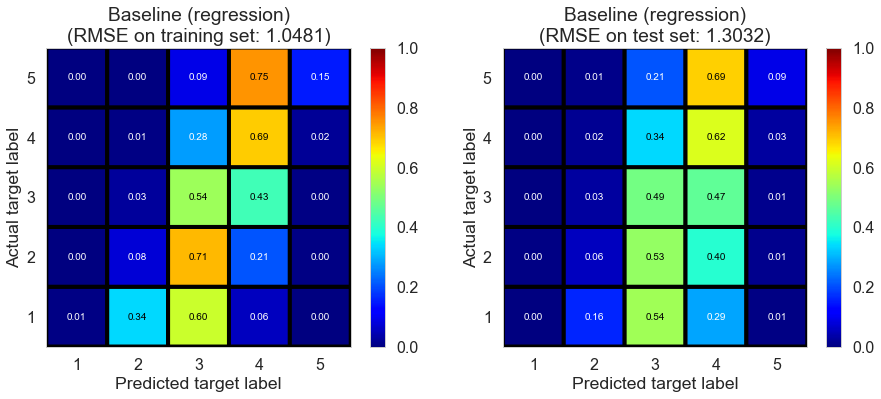

In [15]:
es = BaselineRegression(alpha=2).fit(X_train, y_train)
model_name = 'Baseline (regression)'

results = get_results(es, X_train, y_train, X_test, y_test, X_cv, y_cv)

show_summaries([model_name], [results], [True]);

show_results(es, model_name, X_train, y_train, X_test, y_test, results=results, print_=False, plot=True, \
            show_cv=False, show_title=False);

As we can see, baseline (regression) predicts most ratings to be 3 or 4. The performance of this model is significantly better than previous baseline models, as indicated by larger $R^2$.

### Baseline (ALS)*

We implemented this algorithm by wrapping around [`BaselineOnly`](http://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.baseline_only.BaselineOnly) in the [scikit-surprise](http://surpriselib.com/) package.

Here we also estimate ratings as:
$$\hat{r}_{ui} = \mu + b_u + b_i$$
And we minimize the same regularized squared error:
$$\sum_{r_{ui} \in R_{train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2 +
\lambda \left(b_u^2 + b_i^2 \right).$$

Rather than applying one-hot encoding on `user_id` and `business_id` simultaneously, alternating least squares (ALS), which is the [default algorithm](http://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baseline-estimates-configuration) used in [`BaselineOnly`](http://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.baseline_only.BaselineOnly), is used here for minimizing the regularized squared error.

When we make predictions, if user $u$ is unknown, the bias $b_u$ is assumed to be zero; if the restaurant $i$ is unknown, the bias $b_i$ is assumed to be zero.

We use the default parameters, and the result is shown below.

Estimating biases using als...


model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Baseline (ALS)*,0.139,1.1981,1.32,0.2998,0.1721


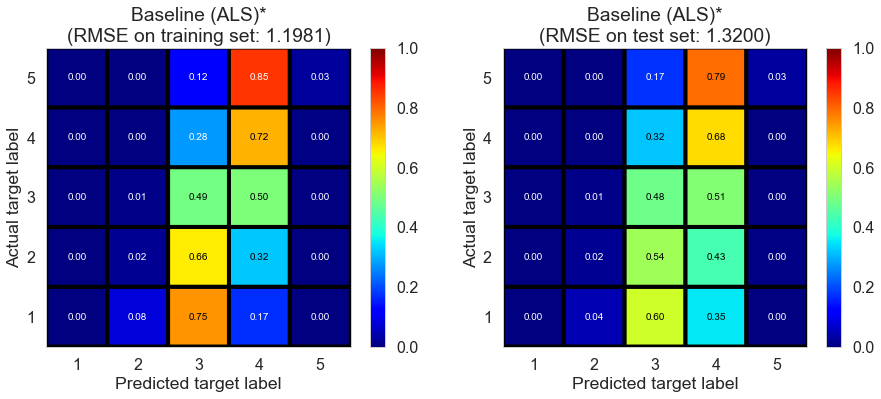

In [27]:
es = RS_surprise(BaselineOnly()).fit(X_train, y_train)
model_name = 'Baseline (ALS)*'

results = get_results(es, X_train, y_train, X_test, y_test, X_cv, y_cv)

show_summaries([model_name], [results], [True]);

show_results(es, model_name, X_train, y_train, X_test, y_test, results=results, print_=False, plot=True, \
            show_cv=False, show_title=False);

The performance on the test set is similar with baseline (regression), while it is worse on the training set, indicating the variance of the model is similar but the bias is higher.

## Latent factor models

Here we tried several matrix factorization-based algorithms, including several different implementations of singular value decomposition ([SVD](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf)) and non-negative matrix factorization ([NMF](http://ieeexplore.ieee.org/document/6748996/)).

### SVD-ALS1

We first implemented sigular value decomposition via alternating least squares ([SVD-ALS](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf)).

We estimate ratings as:
$$\hat{r}_{ui} = \mu + b_u + b_i + q_i^Tp_u$$
where $p_u$ represents the latent factors associated with user $u$, and $q_i$ represents the latent factors associated with restaurant $i$.  
And we minimize the following regularized squared error:
$$\sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right)$$

Two widely used algorithms for solving the above problem are stochastic gradient descent ([SGD](https://en.wikipedia.org/wiki/Stochastic_gradient_descent)) and alternating least squares ([ALS](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf)).

We implement **SVD-ALS1** as follows:
1. Fit a baseline (regression) model with optimized regularization term to learn $\mu$, $b_u$, and $b_i$.
2. Initialize $p_u$ by randomly generating values from a set of IID normal distributions with user defined `init_mean` and `init_std`.
3. In each iteration, we first solve regularized least squares problem for $q_i$ by fixing $p_u$, and then solve for $p_u$ by fixing $q_i$. Specifically, we don't update biases $b_u$ or $b_i$ in each iteration in **SVD-ALS1**. We use [LSMR](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.linalg.lsmr.html) to solve regularized least squares problem in each iteration.

When we make predictions, if user $u$ is unkown, then the bias $b_u$ and the factors $p_u$ are assumed to be zero; if restaurant $i$ is unknown, the bias $b_i$ and the factors $q_i$ are assumed to be zero.

In [17]:
class ALS1(BaselineRegression):
    # not updating biases in each iteration
    def __init__(self, alpha=2, alpha_als=2, rank=100, iterations=5, init_mean=0, init_std=0.1, \
                 random_state=0, classification=False):
        super().__init__(alpha, classification)
        self.alpha_als = alpha_als
        self.rank = rank
        self.iterations = iterations
        self.init_mean = init_mean
        self.init_std = init_std
        self.random_state = random_state
    
    def _fit_ALS_u2m(self):
        self.params_m = np.array([sparse.linalg.lsmr(self.params_u[self.X_u2m[self.ind_u2m[i]:self.ind_u2m[i+1], 0]], \
                                                     self.y_u2m[self.ind_u2m[i]:self.ind_u2m[i+1]], damp=self.alpha_als)[0] \
                                  for i in range(self.n_m)])
        return self
    
    def _fit_ALS_m2u(self):
        self.params_u = np.array([sparse.linalg.lsmr(self.params_m[self.X_m2u[self.ind_m2u[i]:self.ind_m2u[i+1], 1]], \
                                                     self.y_m2u[self.ind_m2u[i]:self.ind_m2u[i+1]], damp=self.alpha_als)[0] \
                                  for i in range(self.n_u)])
        return self
        
    def _fit_ALS(self, X, y):
        df = pd.DataFrame(np.concatenate((X, y.reshape(-1, 1)), axis=1))
        df_u2m = df.sort_values(by=[1, 0]).values
        self.X_u2m = df_u2m[:, :2].astype(int)
        self.y_u2m = df_u2m[:, 2]
        self.ind_u2m = np.concatenate((np.zeros(1, dtype=int), \
                                       np.cumsum(np.bincount(self.X_u2m[:, 1], minlength=self.n_m))))
        df_m2u = df.sort_values(by=[0, 1]).values
        self.X_m2u = df_m2u[:, :2].astype(int)
        self.y_m2u = df_m2u[:, 2]
        self.ind_m2u = np.concatenate((np.zeros(1, dtype=int), \
                                       np.cumsum(np.bincount(self.X_m2u[:, 0], minlength=self.n_u))))
        np.random.seed(self.random_state)
        self.params_u = np.random.normal(self.init_mean, self.init_std, (self.n_u, self.rank))
        for _ in range(self.iterations):
            self._fit_ALS_u2m()
            self._fit_ALS_m2u()
        return self
    
    def fit(self, X, y):
        t0 = time.time()
        X = self._fit_transform_id2index(X)
        y_base = self._fit_baseline_regression(X, y)._predict_no_missing(X)
        self._fit_ALS(X, y-y_base)
        self.fitted = True
        self.time_fitting.append(time.time() - t0)
        return self
    
    def _predict_ALS(self, X):
        return np.array([self.params_u[X[i, 0]].dot(self.params_m[X[i, 1]]) for i in range(len(X))])
    
    def _predict_regression(self, X):
        X = self._transform_id2index(X)
        y = self._predict_baseline(X)
        if self.iterations > 0:
            no_missing = np.logical_and(X[:, 0] != -1, X[:, 1] != -1)
            y[no_missing] = y[no_missing] + self._predict_ALS(X[no_missing])
        return y

We can gain some intuition about the impact of the number of iterations and the number of latent factors on the training and test performance before determining the best parameters through cross-validation.

In [18]:
iterations = [0, 5, 10, 15]
alss = [ALS1(iterations=i, rank=100).fit(X_train, y_train) for i in iterations]

ranks = [0, 5, 10, 20, 50, 100, 200]
alss2 = [ALS1(rank=r, iterations=5).fit(X_train, y_train) for r in ranks]

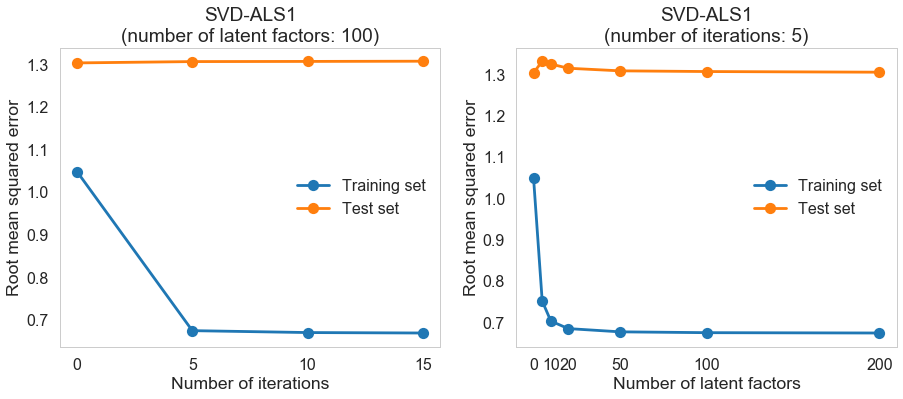

In [20]:
train_rmse = [a.score(X_train, y_train, scoring='rmse') for a in alss]
test_rmse = [a.score(X_test, y_test, scoring='rmse') for a in alss]

plt.figure(figsize=(15, 5.5))
plt.subplot(1, 2, 1)
plt.plot(iterations, train_rmse, 'o-', label='Training set');
plt.plot(iterations, test_rmse, 'o-', label='Test set');
plt.xlabel('Number of iterations');
plt.xticks(iterations, iterations);
plt.ylabel('Root mean squared error');
plt.title('SVD-ALS1\n(number of latent factors: {})'.format(100))
plt.legend();

train_rmse = [a.score(X_train, y_train, scoring='rmse') for a in alss2]
test_rmse = [a.score(X_test, y_test, scoring='rmse') for a in alss2]

plt.subplot(1, 2, 2)
plt.plot(ranks, train_rmse, 'o-', label='Training set');
plt.plot(ranks, test_rmse, 'o-', label='Test set');
plt.xlabel('Number of latent factors');
plt.xticks([0] + ranks[2:], [0] + ranks[2:]);
plt.ylabel('Root mean squared error');
plt.title('SVD-ALS1\n(number of iterations: {})'.format(5))
plt.legend();

The performance on the training set improves significantly compared to baseline (regression) model when the number of iterations and the number of latent factors are not too small; the performance on the test set doesn't change much.

We can determine the best parameters through cross-validation. And we can test the performance of the algorithm on our dataset.

In [21]:
alphas = [1, 2, 4]
alphas_als = [0.3, 1, 3, 10]
its = [5, 10, 15]
ranks = [10, 20, 50, 100]

#gs_als1 = GridSearchCV(ALS1(classification=False), \
                       #param_grid={'alpha':alphas, 'alpha_als':alphas_als, 'iterations':its, 'rank':ranks}, \
                       #scoring='neg_mean_squared_error', cv=3, return_train_score=True).fit(X_train, y_train)

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
SVD-ALS1,13.7668,0.6747,1.3064,0.778,0.1891


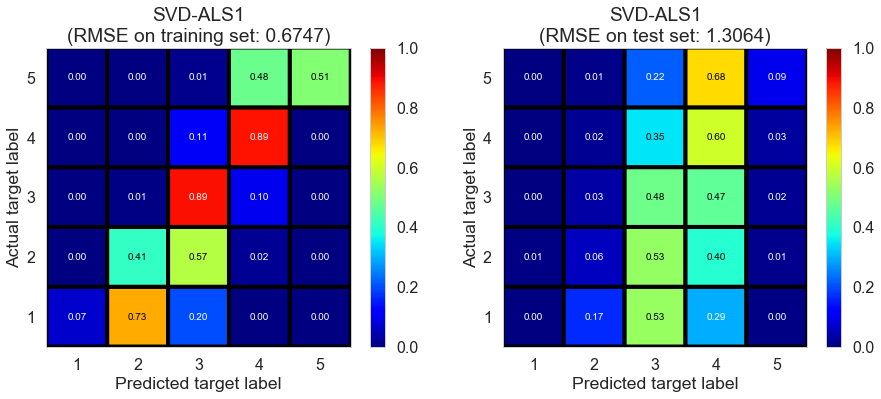

In [22]:
es = ALS1().fit(X_train, y_train)
model_name = 'SVD-ALS1'

results = get_results(es, X_train, y_train, X_test, y_test, X_cv, y_cv)

show_summaries([model_name], [results], [True]);

show_results(es, model_name, X_train, y_train, X_test, y_test, results=results, print_=False, plot=True, \
            show_cv=False, show_title=False);

The performance on the test set doesn't change much but the performance on the training set improves significantly compared to baseline (regression) model. **SVD-ALS1** significantly decreases the bias of the model without significantly increasing the variance. 

### SVD-ALS2

Different from **SVD-ALS1**, **SVD-ALS2** updates biases $b_u$ or $b_i$ in each iteration.

We estimate ratings as:
$$\hat{r}_{ui} = \mu + b_u + b_i + q_i^Tp_u$$
where $p_u$ represents the latent factors associated with user $u$, and $q_i$ represents the latent factors associated with restaurant $i$.  
And we minimize the following regularized squared error:
$$\sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right)$$

We implement **SVD-ALS2** as follows:
1. Fit a baseline (regression) model with optimized regularization term to learn $\mu$, $b_u$, and $b_i$.
2. Initialize $p_u$ by randomly generating values from a set of IID normal distributions with user defined `init_mean` and `init_std`.
3. In each iteration, we first solve regularized least squares problem for $q_i$ and $b_i$ by fixing $p_u$ and $b_u$, and then solve for $p_u$ and $b_u$ by fixing $q_i$ and $b_i$. Specifically, we update biases $b_u$ or $b_i$ in each iteration in **SVD-ALS2**. We use [LSMR](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.linalg.lsmr.html) to solve regularized least squares problem at each iteration.

When we make predictions, if user $u$ is unkown, then the bias $b_u$ and the factors $p_u$ are assumed to be zero; if restaurant $i$ is unknown, the bias $b_i$ and the factors $q_i$ are assumed to be zero.

In [23]:
iterations = [0, 5, 10, 15]
als2s = [ALS2(iterations=i, rank=100).fit(X_train, y_train) for i in iterations]

ranks = [0, 5, 10, 20, 50, 100, 200]
als2s2 = [ALS2(rank=r, iterations=5).fit(X_train, y_train) for r in ranks]

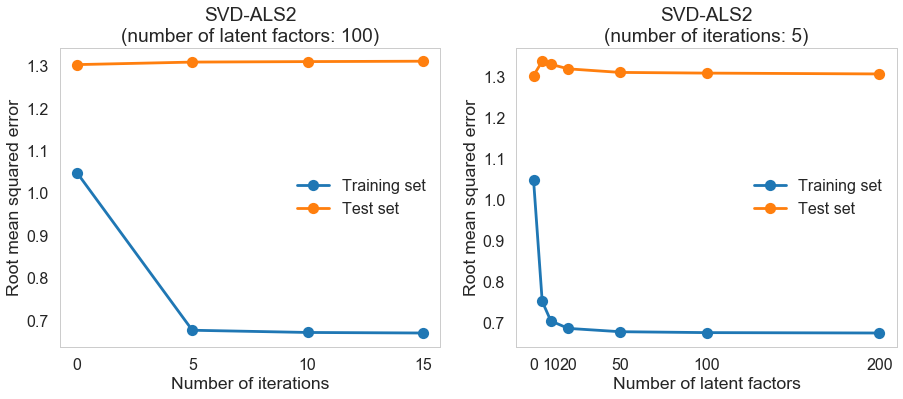

In [24]:
train_rmse = [a.score(X_train, y_train, scoring='rmse') for a in als2s]
test_rmse = [a.score(X_test, y_test, scoring='rmse') for a in als2s]

plt.figure(figsize=(15, 5.5))
plt.subplot(1, 2, 1)
plt.plot(iterations, train_rmse, 'o-', label='Training set');
plt.plot(iterations, test_rmse, 'o-', label='Test set');
plt.xlabel('Number of iterations');
plt.xticks(iterations, iterations);
plt.ylabel('Root mean squared error');
plt.title('SVD-ALS2\n(number of latent factors: {})'.format(100))
plt.legend();

train_rmse = [a.score(X_train, y_train, scoring='rmse') for a in als2s2]
test_rmse = [a.score(X_test, y_test, scoring='rmse') for a in als2s2]

plt.subplot(1, 2, 2)
plt.plot(ranks, train_rmse, 'o-', label='Training set');
plt.plot(ranks, test_rmse, 'o-', label='Test set');
plt.xlabel('Number of latent factors');
plt.xticks([0] + ranks[2:], [0] + ranks[2:]);
plt.ylabel('Root mean squared error');
plt.title('SVD-ALS2\n(number of iterations: {})'.format(5))
plt.legend();

We can determine the best parameters through cross-validation. And we can test the performance of the algorithm on our dataset.

In [25]:
alphas = [1, 2, 4]
alphas_als = [0.3, 1, 3, 10]
its = [5, 10, 15]
ranks = [10, 20, 50, 100]

#gs_als2 = GridSearchCV(ALS2(classification=False), \
                       #param_grid={'alpha':alphas, 'alpha_als':alphas_als, 'iterations':its, 'rank':ranks}, \
                       #scoring='neg_mean_squared_error', cv=3, return_train_score=True).fit(X_train, y_train)

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
SVD-ALS2,26.5325,0.6712,1.3104,0.7803,0.1841


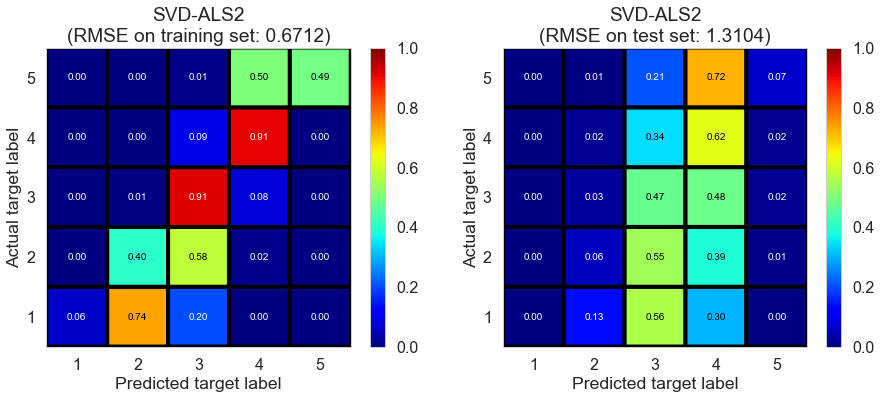

In [26]:
es = ALS2().fit(X_train, y_train)
model_name = 'SVD-ALS2'

results = get_results(es, X_train, y_train, X_test, y_test, X_cv, y_cv)

show_summaries([model_name], [results], [True]);

show_results(es, model_name, X_train, y_train, X_test, y_test, results=results, print_=False, plot=True, \
            show_cv=False, show_title=False);

The result of **SVD-ALS2** is similar to that of **SVD-ALS1**, indicating updating biases in each iteration don't have much impact on the model performance.

### SVD-SGD*

We implemented this algorithm by wrapping around [`SVD`](http://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD) in the [scikit-surprise](http://surpriselib.com/) package.

Stochastic gradient descent (SGD) is another widely used algorithm for solving SVD problems.

We estimate ratings as:
$$\hat{r}_{ui} = \mu + b_u + b_i + q_i^Tp_u$$
where $p_u$ represents the latent factors associated with user $u$, and $q_i$ represents the latent factors associated with restaurant $i$.  
And we minimize the following regularized squared error:
$$\sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right)$$

As described in [documentation](http://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD), **SVD-SGD\*** performs minization by stachastic gradient descent:
$$b_u \leftarrow b_u + \gamma (e_{ui} - \lambda b_u)$$
$$b_i \leftarrow b_i + \gamma (e_{ui} - \lambda b_i)$$
$$p_u \leftarrow p_u + \gamma (e_{ui} \cdot q_i - \lambda p_u)$$
$$q_i \leftarrow q_i + \gamma (e_{ui} \cdot p_u - \lambda q_i)$$
where $e_{ui} = r_{ui} - \hat{r}_{ui}$.

We use the default parameters, and the result is shown below.

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
SVD-SGD*,1.0221,0.8909,1.3167,0.6129,0.1761


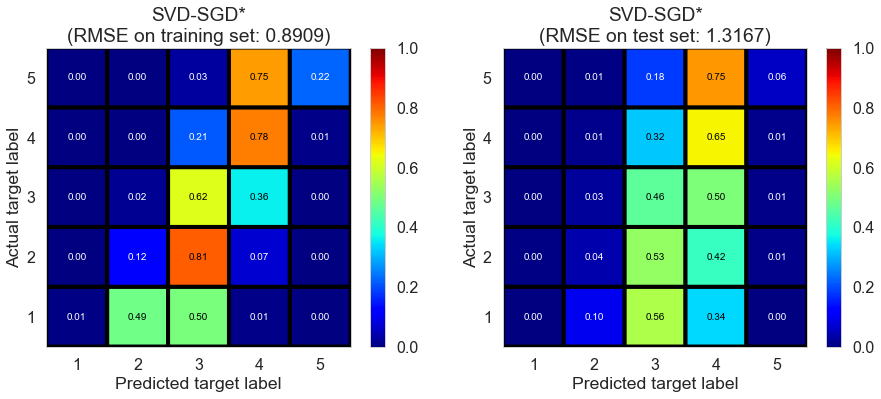

In [29]:
es = RS_surprise(SVD()).fit(X_train, y_train)
model_name = 'SVD-SGD*'

results = get_results(es, X_train, y_train, X_test, y_test, X_cv, y_cv)

show_summaries([model_name], [results], [True]);

show_results(es, model_name, X_train, y_train, X_test, y_test, results=results, print_=False, plot=True, \
            show_cv=False, show_title=False);

The result of **SVD-SGD\*** is similar to that of **SVD-ALS1** and **SVD-ALS2**.

### Surprise

In [14]:
class RS_surprise(BaselineRegression):
    def __init__(self, estimator=BaselineOnly(), classification=False):
        self.estimator = estimator
        self.fitted = False
        self.classification = classification
        self.time_fitting = []
        self.time_predict = []
        
    def fit(self, X, y):
        t0 = time.time()
        df = pd.DataFrame(np.concatenate((X, y.reshape(-1, 1)), axis=1))
        d = Dataset.load_from_df(df, Reader(rating_scale=(1, 5)))
        data = d.build_full_trainset()
        self.estimator.train(data)
        self.fitted = True
        self.time_fitting.append(time.time() - t0)
        return self
    
    def _predict_regression(self, X):
        y_pred = np.array([self.estimator.predict(_x[0], _x[1]).est for _x in X])
        return y_pred

In [15]:
def print_results(es, model_name='', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, \
                  classification=True, plot=True, figname=None):
    print(model_name)
    print('Fitting time: {} s.'.format(es.time_fitting[-1]))
    print('RMSE on training set: {}.'.format(es.score(X_train, y_train, scoring='rmse')))
    print('RMSE on test set: {}.'.format(es.score(X_test, y_test, scoring='rmse')))
    if classification:
        print('Classification accuracy on training set: {}.'.format(es.score(X_train, y_train, classification=True)))
        print('Classification accuracy on test set: {}.'.format(es.score(X_test, y_test, classification=True)))
        if plot:
            y_pred_train_label = es.predict(X_train, classification=True)
            y_pred_test_label = es.predict(X_test, classification=True)
            plt.figure(figsize=(15, 5.5))
            plt.subplot(1, 2, 1)
            plot_cm(confusion_matrix(y_train, y_pred_train_label), model_name + '\n(on training set)')
            plt.subplot(1, 2, 2)
            plot_cm(confusion_matrix(y_test, y_pred_test_label), model_name + '\n(on test set)')
            plt.show()
            
            if figname is not None:
                plt.savefig(figname, bbox_inches='tight')
            
        print()

In [16]:
models = [NormalPredictor(), BaselineOnly(), KNNBasic(), KNNWithMeans(), \
          KNNBaseline(), SVD(), SVDpp(), NMF(), SlopeOne(), CoClustering()]
model_names = ['NormalPredictor', 'BaselineOnly', 'KNNBasic', 'KNNWithMeans', 'KNNBaseline',\
               'SVD-SGD', 'SVD++-SGD', 'NMF', 'Slope One', 'Co-clustering']

In [17]:
estimators = [RS_surprise(model).fit(X_train, y_train) for model in models]

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


NormalPredictor
Fitting time: 0.039002180099487305 s.
RMSE on training set: 1.8528450891755022.
RMSE on test set: 1.878589142462863.
Classification accuracy on training set: 0.21623723869713174.
Classification accuracy on test set: 0.21368850865253744.


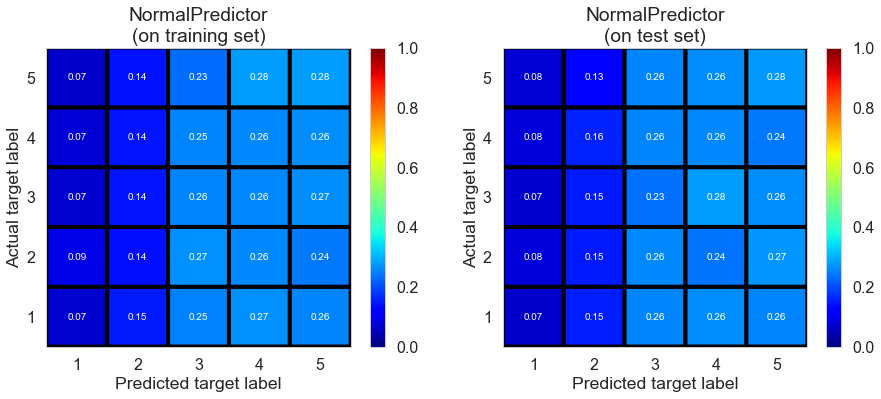


BaselineOnly
Fitting time: 0.04800295829772949 s.
RMSE on training set: 1.2014954967892566.
RMSE on test set: 1.3287295686669602.
Classification accuracy on training set: 0.2542537676227516.
Classification accuracy on test set: 0.2302158273381295.


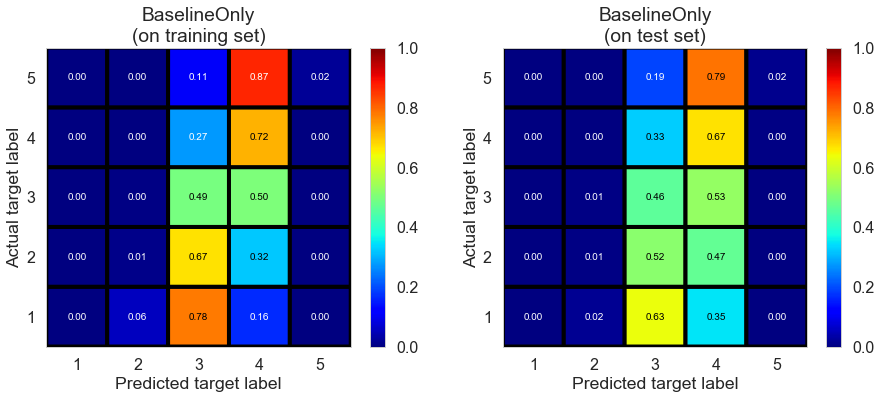


KNNBasic
Fitting time: 0.7380421161651611 s.
RMSE on training set: 0.4399972131116988.
RMSE on test set: 1.4759531964719492.
Classification accuracy on training set: 0.7767622751579971.
Classification accuracy on test set: 0.24450709702508264.


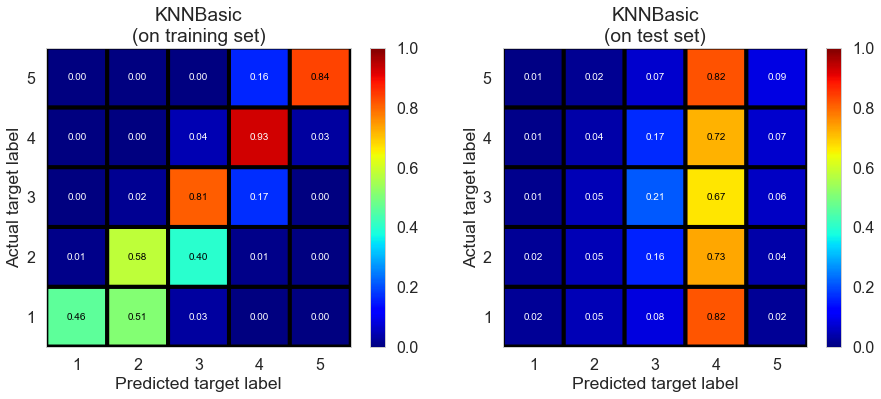


KNNWithMeans
Fitting time: 0.8770503997802734 s.
RMSE on training set: 0.5733644539136411.
RMSE on test set: 1.5450271833493001.
Classification accuracy on training set: 0.7019931939718036.
Classification accuracy on test set: 0.2745479292241882.


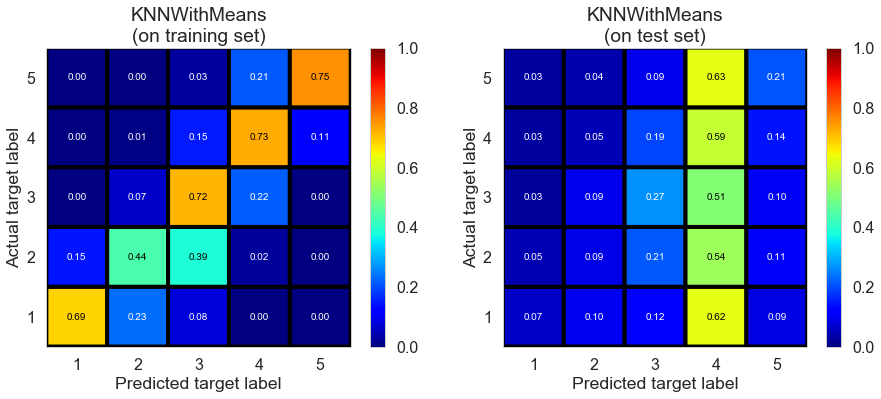


KNNBaseline
Fitting time: 0.7580432891845703 s.
RMSE on training set: 0.42240311718361273.
RMSE on test set: 1.3873552528535935.
Classification accuracy on training set: 0.7914438502673797.
Classification accuracy on test set: 0.24052109663620455.


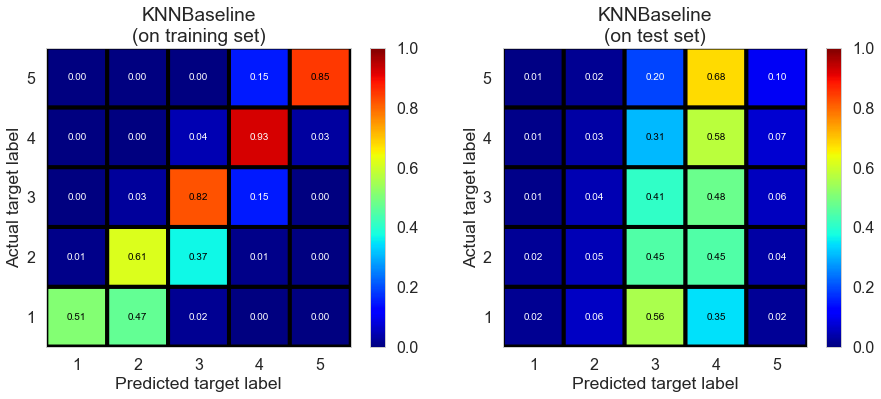


SVD-SGD
Fitting time: 0.832047700881958 s.
RMSE on training set: 0.8989534235687345.
RMSE on test set: 1.3269862343402865.
Classification accuracy on training set: 0.36596985901798734.
Classification accuracy on test set: 0.23984055998444487.


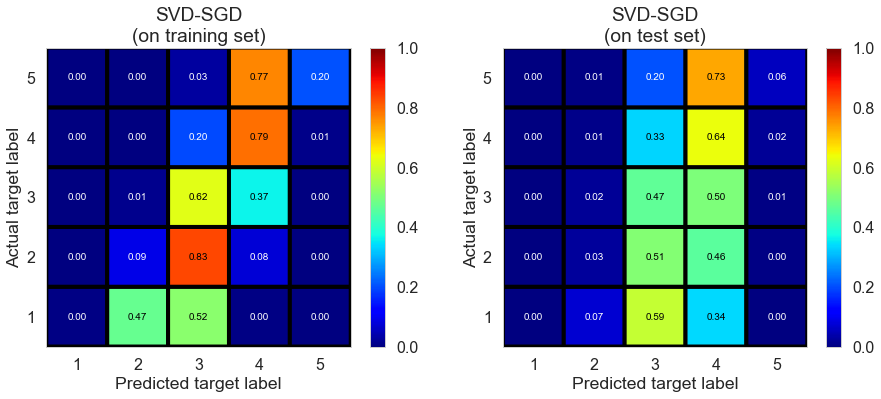


SVD++-SGD
Fitting time: 2.514143705368042 s.
RMSE on training set: 0.9385908380970216.
RMSE on test set: 1.3266237958071285.
Classification accuracy on training set: 0.3683033543996111.
Classification accuracy on test set: 0.2391600233326852.


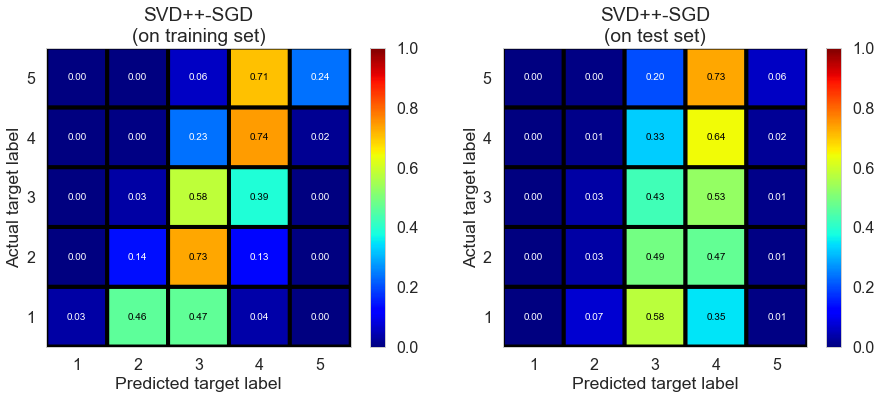


NMF
Fitting time: 1.0240585803985596 s.
RMSE on training set: 0.22344915569954915.
RMSE on test set: 1.5209668981529503.
Classification accuracy on training set: 0.949538162372387.
Classification accuracy on test set: 0.25111802449931947.


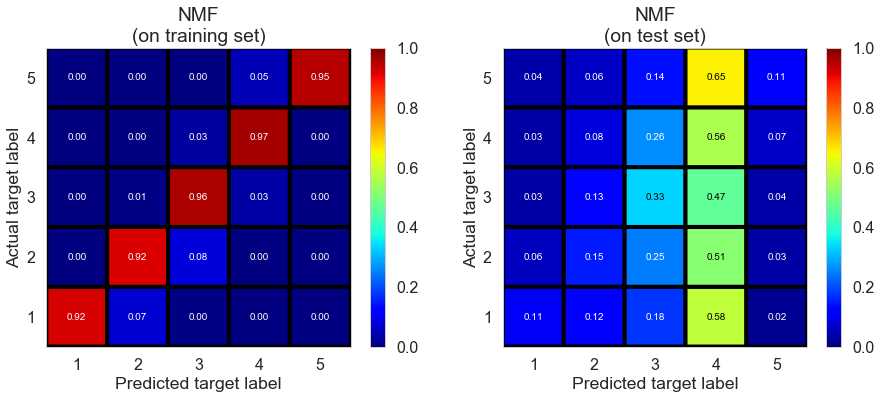


Slope One
Fitting time: 0.12700724601745605 s.
RMSE on training set: 0.3097341323753317.
RMSE on test set: 1.5704662208892703.
Classification accuracy on training set: 0.895478852698104.
Classification accuracy on test set: 0.2656037332296325.


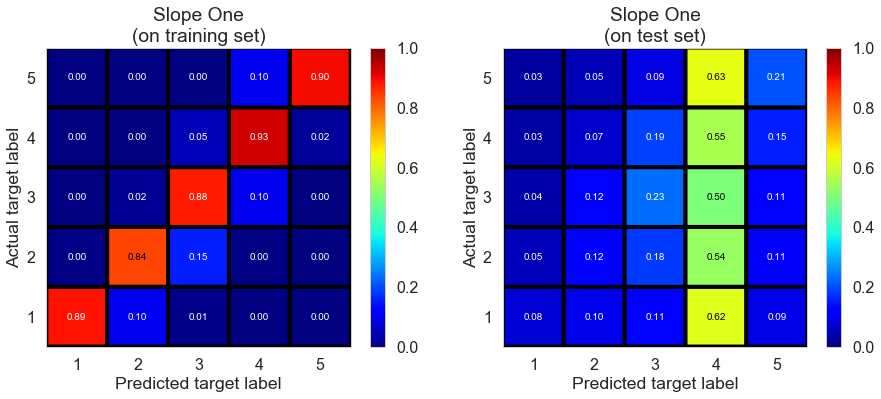


Co-clustering
Fitting time: 1.077061653137207 s.
RMSE on training set: 0.7759311775303401.
RMSE on test set: 1.490094777017588.
Classification accuracy on training set: 0.6109868740884784.
Classification accuracy on test set: 0.28640871086914255.


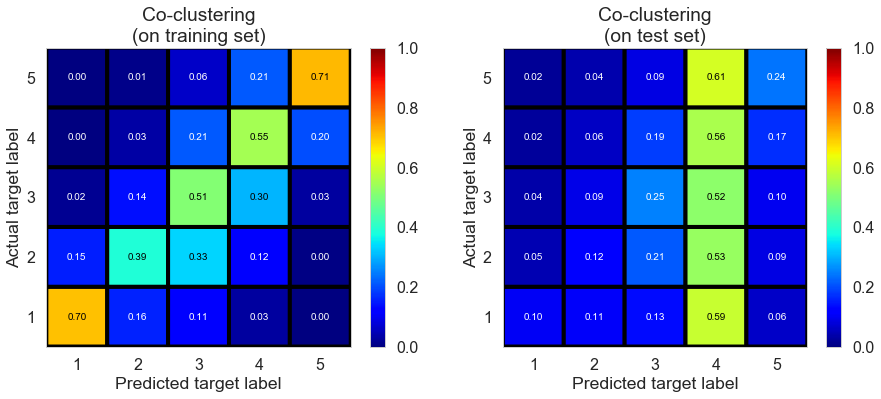

In [18]:
for i in range(len(models)):
    print_results(estimators[i], model_names[i])